# ANALISIS SENTIMEN FILM

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
data_dir = 'aclImdb'
folders = [
    ('train', 'neg', 'negative'),
    ('train', 'pos', 'positive'),
    ('test', 'neg', 'negative'),
    ('test', 'pos', 'positive')
]

In [6]:
data = []
for split, sentiment, label in folders:
    folder_path = os.path.join(data_dir, split, sentiment)
    for filename in os.listdir(folder_path):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            text = file.read()
            data.append({ 'split': split, 'label': label,'text': text})

In [7]:
# Pertama kali
df = pd.DataFrame(data)
df.to_csv("imdb_dataset.csv", index=False)

In [8]:
df = pd.read_csv("imdb_dataset.csv")

In [9]:
print(df.head())

   split     label                                               text
0  train  negative  Story of a man who has unnatural feelings for ...
1  train  negative  Airport '77 starts as a brand new luxury 747 p...
2  train  negative  This film lacked something I couldn't put my f...
3  train  negative  Sorry everyone,,, I know this is supposed to b...
4  train  negative  When I was little my parents took me along to ...


In [10]:
print(df.tail())

      split     label                                               text
49995  test  positive  I was extraordinarily impressed by this film. ...
49996  test  positive  Although I'm not a golf fan, I attended a snea...
49997  test  positive  From the start of "The Edge Of Love", the view...
49998  test  positive  This movie, with all its complexity and subtle...
49999  test  positive  I've seen this story before but my kids haven'...


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   split   50000 non-null  object
 1   label   50000 non-null  object
 2   text    50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [13]:
print(df.head()[['split','label', 'text']])
print(f"Jumlah test data positif: {len(df)}")

   split     label                                               text
0  train  negative  Story of a man who has unnatural feelings for ...
1  train  negative  Airport '77 starts as a brand new luxury 747 p...
2  train  negative  This film lacked something I couldn't put my f...
3  train  negative  Sorry everyone,,, I know this is supposed to b...
4  train  negative  When I was little my parents took me along to ...
Jumlah test data positif: 50000


In [14]:
print("Contoh test data negatif:")
print(df.head()[['split','label', 'text']])
print(f"Jumlah test data negatif: {len(df)}")

Contoh test data negatif:
   split     label                                               text
0  train  negative  Story of a man who has unnatural feelings for ...
1  train  negative  Airport '77 starts as a brand new luxury 747 p...
2  train  negative  This film lacked something I couldn't put my f...
3  train  negative  Sorry everyone,,, I know this is supposed to b...
4  train  negative  When I was little my parents took me along to ...
Jumlah test data negatif: 50000


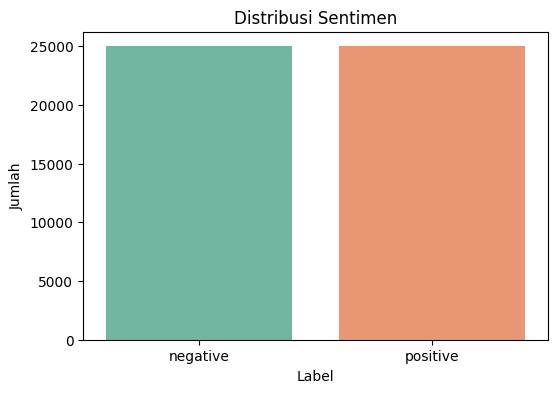

In [15]:
# === Visualisasi: Distribusi Label ===
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', hue='label', palette='Set2', legend=False)
plt.title("Distribusi Sentimen")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

In [16]:
# === Split Data ===
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [17]:
# === Vectorization ===
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

In [18]:
# === Naive Bayes Multinomial Training ===
def train_multinomial_nb(X_train, y_train):
    y_train = np.array(y_train)
    classes = np.unique(y_train)
    priors = {c: np.sum(y_train == c) / len(y_train) for c in classes}
    likelihoods = {}
    for c in classes:
        class_docs = X_train[y_train == c]
        word_counts = class_docs.sum(axis=0)
        total_words = word_counts.sum()
        likelihoods[c] = (word_counts + 1) / (total_words + X_train.shape[1])
    return priors, likelihoods

In [19]:
# === Prediction Function ===
def predict_sentiment(review, vectorizer, priors, likelihoods):
    X_new = vectorizer.transform([review])
    probs = {c: np.log(priors[c]) for c in priors}
    for i, count in zip(X_new.indices, X_new.data):
        for c in priors:
            probs[c] += np.log(likelihoods[c][0, i]) * count
    return max(probs, key=probs.get)

In [20]:
# === Evaluation Function ===
def evaluate_multinomial_nb(X_test, y_test, priors, likelihoods):
    y_pred = []
    y_test = np.array(y_test)
    for doc in X_test:
        probs = {c: np.log(priors[c]) for c in priors}
        for i, count in zip(doc.indices, doc.data):
            for c in priors:
                probs[c] += np.log(likelihoods[c][0, i]) * count
        y_pred.append(max(probs, key=probs.get))
    accuracy = np.sum(np.array(y_pred) == y_test) / len(y_test)
    return accuracy, y_pred

In [21]:
# === Train and Evaluate ===
priors, likelihoods = train_multinomial_nb(X_train_counts, y_train)
accuracy, y_pred = evaluate_multinomial_nb(X_test_counts, y_test, priors, likelihoods)
print(f"Accuracy on test set: {accuracy:.2f}")

Accuracy on test set: 0.85


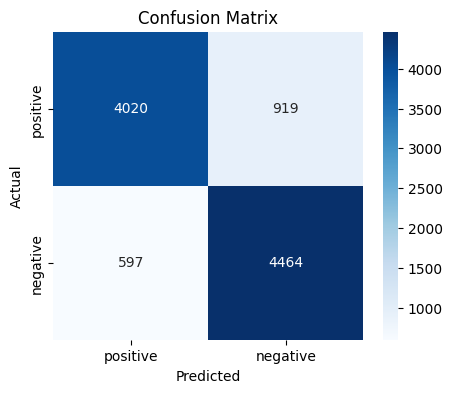

In [22]:
# === Confusion Matrix & Classification Report ===
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["positive", "negative"], yticklabels=["positive", "negative"], cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [23]:
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["positive", "negative"]))

📊 Classification Report:
              precision    recall  f1-score   support

    positive       0.83      0.88      0.85      5061
    negative       0.87      0.81      0.84      4939

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [24]:
# === Contoh Prediksi ===
sample_review = "The movie was fantastic and engaging"
prediction = predict_sentiment(sample_review, vectorizer, priors, likelihoods)
print(f"Review: '{sample_review}' \n=> Sentiment: {prediction}")

Review: 'The movie was fantastic and engaging' 
=> Sentiment: positive
